In [22]:
# HORN network module
# Felix Effenberger, July 21, 2023

import math

import matplotlib.pyplot as plt
import torch
from tqdm import tqdm


# HORN model
class KCM(torch.nn.Module):

    def __init__(self, num_input, num_nodes, num_output, n_states, p, sigma):
        super().__init__()

        self.num_input = num_input
        self.num_nodes = num_nodes
        self.num_output = num_output

        # hyperparameters
        self.p = p
        self.sigma = sigma
        self.n_states = n_states

        # Create connectivity matrix
        pmax = 2 * sigma / num_nodes
        W = torch.rand(num_nodes, num_nodes)
        W = (W + W.T) / 2
        self.W = (W >= 0.967) * W * pmax
        self.W.fill_diagonal_(0)

        # input, recurrent and output layers
        self.i2h = torch.nn.Linear(num_input, num_nodes)
        self.h2h = torch.nn.Linear(num_nodes, num_nodes)
        self.h2o = torch.nn.Linear(num_nodes, num_output)

        self.dynamics_step_vmap = torch.func.vmap(
            self.dynamics_step, in_dims=(0, 0), randomness="different"
        )

    def dynamics_step(self, states, input_t):

        ####################################################################
        # Quiet cells may be activated and update cells
        ####################################################################
        Q = states == 0
        R = states >= 1
        # Check if any quiescent goes active
        dice_A = torch.rand(self.num_nodes) < self.p

        ####################################################################
        # Excited cells may update neighbors
        ####################################################################
        E = states == 1

        dice_B = (torch.rand(self.num_nodes, self.num_nodes) < E * self.W).any(axis=1)

        new_states = (
            torch.logical_and(Q, dice_A)
            + torch.logical_and(Q, dice_B)
            + ((states + 1) % self.n_states) * R
        ).type(torch.float32)

        return new_states

    def forward(self, batch, random_init=None, record=False):
        # batch has shape: (time steps, batch size, ...)
        batch_size = batch.size(1)
        num_timesteps = batch.size(0)

        ret = {}

        if record:
            # record dynamics of x_t, y_t
            rec_states = torch.zeros(batch_size, num_timesteps, self.num_nodes)
            ret["rec_states"] = rec_states

        # initial conditions for variables x, y for each DHO node

        states = torch.randint(0, self.n_states, (batch_size, self.num_nodes))

        # make x_t, y_t autograd variables for automatic differentiation
        states_t = torch.autograd.Variable(states)
        print(states_t.shape)
        # loop over all time steps, feeding one pixel per time step
        for t in tqdm(range(num_timesteps)):
            # compute one dynamics step and update x_t, y_t
            states_t = self.dynamics_step_vmap(states_t, batch.T)

            if record:
                ret["rec_states"][:, t, :] = states_t

        # linear readout at last time step
        output = self.h2o(states_t)

        ret["output"] = output
        return ret

In [23]:
model = KCM(1, 5000, 1, 5, 0.01, 1)

In [24]:
batch = torch.zeros(1, 1, 1000).permute(2, 0, 1)

In [25]:
batch.shape

torch.Size([1000, 1, 1])

In [26]:
out = model(batch, record=True)["rec_states"].detach().numpy()

torch.Size([1, 5000])


100%|████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.68it/s]


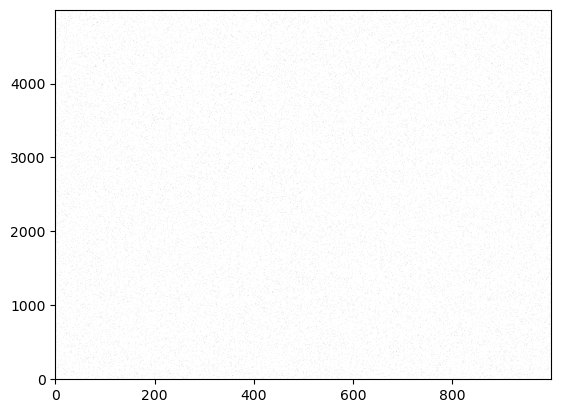

In [27]:
plt.imshow((out[0] == 1).T, aspect="auto", cmap="binary", origin="lower")

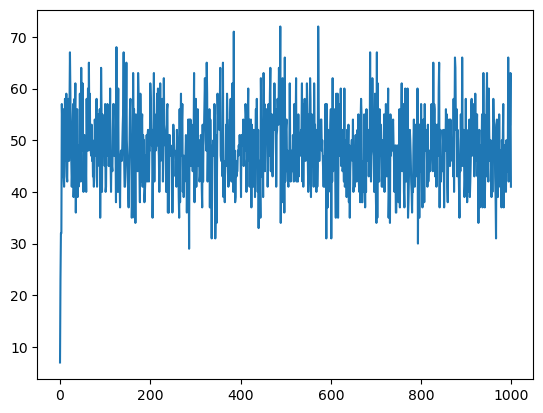

In [28]:
plt.plot((out[0] == 1).sum(1))